## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn.metrics import roc_curve
from numpy import arange
from sklearn.metrics import f1_score
from numpy import argmax

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
53781,00013584_001.png,No Finding,1,13584,62,M,PA,2500,2048,0.168000,0.168000,NaN,/data/images_006/images/00013584_001.png
107940,00029196_000.png,Nodule,0,29196,49,F,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029196_000.png
82789,00020339_001.png,Infiltration,1,20339,28,F,AP,3056,2544,0.139000,0.139000,NaN,/data/images_009/images/00020339_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
8554,00002262_014.png,Atelectasis,14,2262,72,M,PA,2476,2561,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19010,00005066_006.png,No Finding,6,5066,49,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78136,00019176_046.png,Consolidation|Infiltration,46,19176,66,F,PA,2630,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

def get_pneumonia_class(row):
    if row['Pneumonia'] < 0.5:
        return "no-pneumonia"
    else:
        return "pneumonia"

# Todo
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: get_pneumonia_class(row), axis=1)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no-pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no-pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no-pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no-pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no-pneumonia


## Create your training and testing data:

In [5]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    
    return train_data, val_data

In [6]:
train_df, valid_df = create_splits(all_xray_df)

In [7]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [8]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

Great, our train_test_split made sure that we had the same proportions of pneumonia in both sets!

### Condition 1 - To have _EQUAL_ amount of positive and negative cases of pneumonia in Training 
But.... we know that we want our model to be trained on a set that has _equal_ proportions of pneumonia and no pneumonia, so we're going to have to throw away some data:

In [9]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [10]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

Ta-da! We randomly chose a set of non-pneumonia images using the sample() function that was the same length as the number of true pneumonia cases we had, and then we threw out the rest of the non-pneumonia cases. Now our training dataset is balanced 50-50.

### Condition 2 - To have 1% positive cases of Pneumonia in the Test Set
Finally, we want to make the balance in our validation set more like 1-99 since our exploratory data analysis told us that the prevalence of pneumonia in this clinical situation is about 1%:

In [11]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()
print("pneumonia count:    ", len(p_inds))
print("non-pneumonia count:", len(np_inds))

pneumonia count:     286
non-pneumonia count: 22138


In [12]:
# The following code pulls a random sample of pneumonia data that's 1/99 times as big as the non-pneumonia sample.
p_sample = sample(p_inds, int(round(1.0 / 99.0 * len(np_inds))))
valid_df = valid_df.loc[np_inds + p_sample]

In [13]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()
print("pneumonia count:    ", len(p_inds))
print("non-pneumonia count:", len(np_inds))
print("pneumonia %:        ", round(100 * len(p_inds) / len(np_inds)))

pneumonia count:     224
non-pneumonia count: 22138
pneumonia %:         1


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

In [15]:
def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 32
                                          )
     # Todo

    return train_gen


def make_val_gen(my_val_idg, val_data):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = IMG_SIZE, 
                                              batch_size = 32) 
    
    # Todo
    return val_gen

In [16]:
train_idg = my_image_augmentation(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

In [17]:
val_idg = my_image_augmentation(rescale=1. / 255.0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range= 0.0, 
                              width_shift_range=0.0, 
                              rotation_range=0, 
                              shear_range = 0.0,
                              zoom_range=0.0)

In [18]:
train_gen = make_train_gen(train_idg, train_df)
print(train_gen.class_indices)

Found 2290 validated image filenames belonging to 2 classes.
{'no-pneumonia': 0, 'pneumonia': 1}


In [19]:
val_gen = make_val_gen(val_idg, valid_df)

Found 22362 validated image filenames belonging to 2 classes.


In [20]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

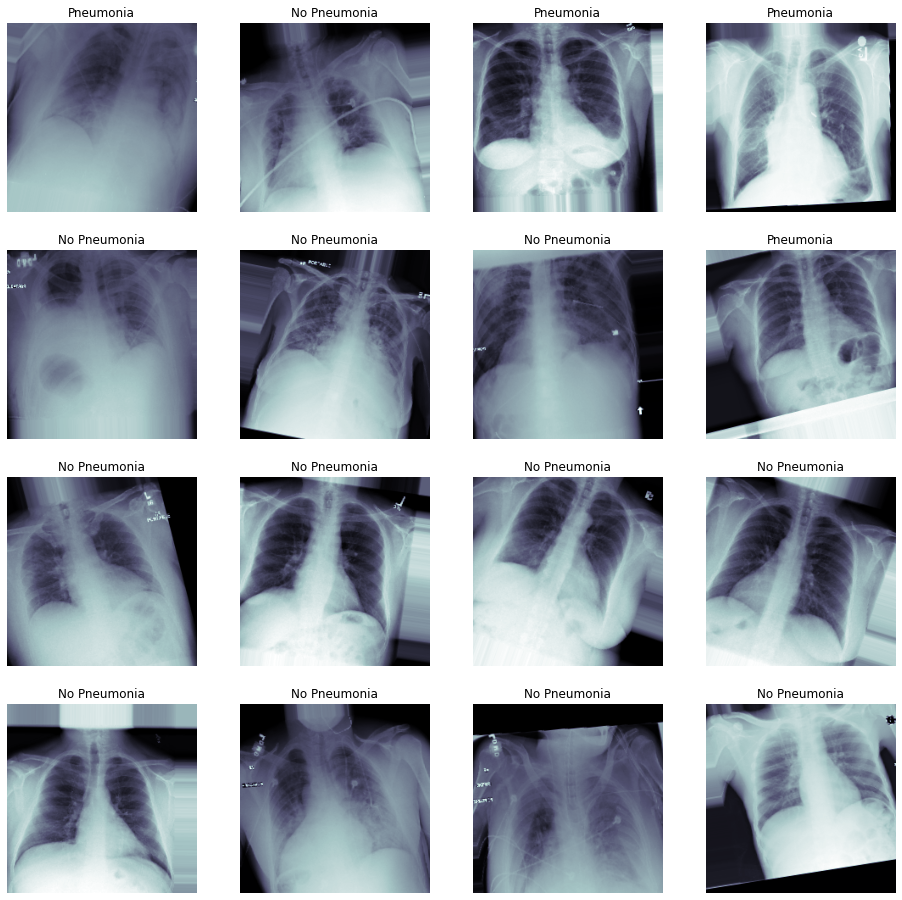

In [21]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 0: 
        c_ax.set_title('No Pneumonia')
    else:
        c_ax.set_title('Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [22]:
def load_pretrained_model(lay_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model

In [50]:
def build_my_model():
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    vgg_model = load_pretrained_model('block5_pool')
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False    

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    my_model.add(Flatten())
    my_model.add(Dropout(0.1))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.1))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.1))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))

    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [51]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [52]:
## train your model

# Todo
my_model = build_my_model()
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 5, 
                           callbacks = callbacks_list)

Epoch 1/5
72/72 [==============================] - 60s 829ms/step - loss: 0.7069 - binary_accuracy: 0.5349 - val_loss: 0.5366 - val_binary_accuracy: 0.7812

Epoch 00001: val_loss improved from inf to 0.53656, saving model to xray_class_my_model.best.hdf5
Epoch 2/5
72/72 [==============================] - 59s 823ms/step - loss: 0.6765 - binary_accuracy: 0.5838 - val_loss: 0.6762 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.53656
Epoch 3/5
72/72 [==============================] - 59s 820ms/step - loss: 0.6572 - binary_accuracy: 0.6022 - val_loss: 0.6264 - val_binary_accuracy: 0.6562

Epoch 00003: val_loss did not improve from 0.53656
Epoch 4/5
72/72 [==============================] - 59s 819ms/step - loss: 0.6556 - binary_accuracy: 0.6266 - val_loss: 0.8191 - val_binary_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.53656
Epoch 5/5
72/72 [==============================] - 59s 817ms/step - loss: 0.6443 - binary_accuracy: 0.6358 - val_loss: 0.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [53]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 13ms/step


In [54]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, _ = roc_curve(t_y, p_y)
    plt.plot(fpr, tpr, label='Pneumonia')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")    
    # Todo

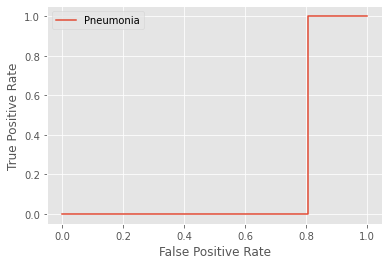

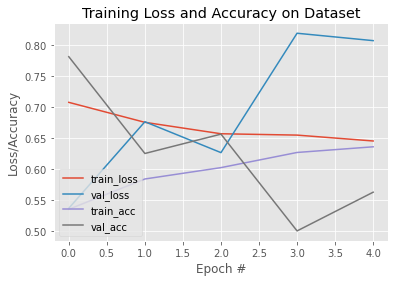

In [55]:
## plot figures

# Todo
plot_auc(valY, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [70]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
yhat = my_model.predict_proba(valX)
thresholds = arange(0, 1, 0.001)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

scores = [f1_score(valY, to_labels(yhat, t)) for t in thresholds]
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.257, F-Score=0.07407


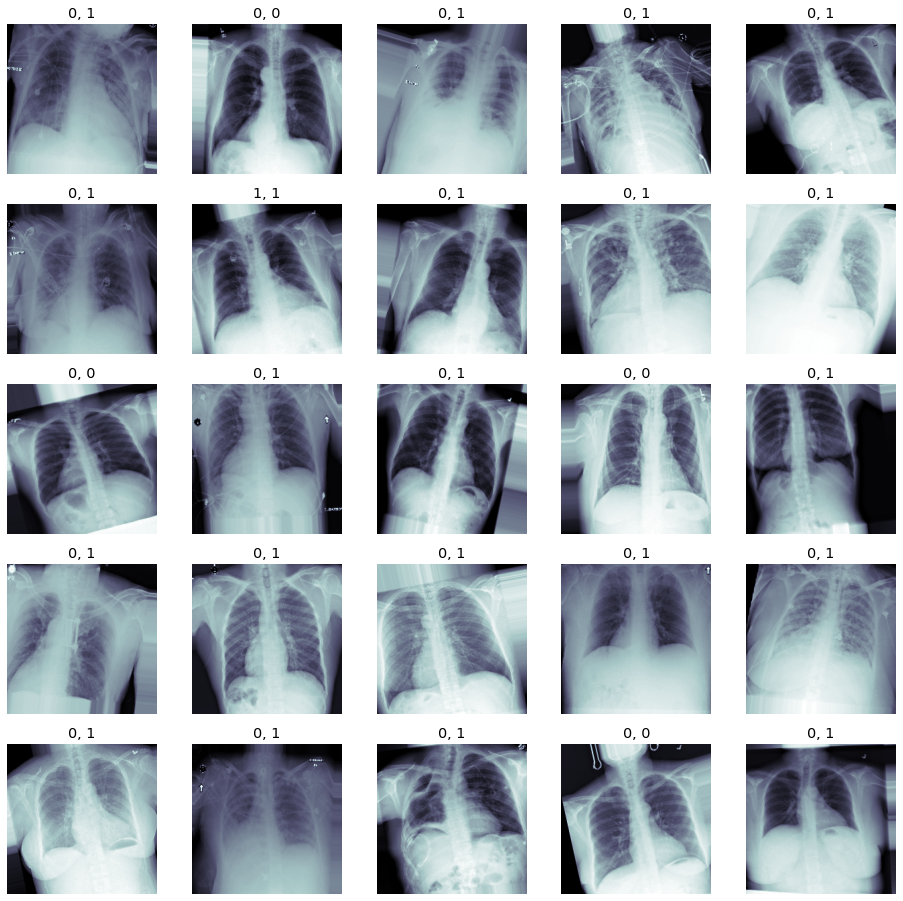

In [76]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > 0.257:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > 0.257: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [77]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)